# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 3 - Forecasting Bike Sharing Usage



**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.

Names of people you have worked with goes here: 

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Subset Selection, Polynomial Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore techniques for subset selection to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).


### Use only the libraries below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline

In [3]:
# define figure defaults
mpl.rc('axes', labelsize=14, titlesize=14)
mpl.rc('figure', figsize=[8,6], titlesize=16)
mpl.rc('legend', fontsize=14)
mpl.rc('lines', linewidth=2, color='k')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

## Data Exploration & Preprocessing, Multiple Linear Regression, Subset Selection


### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius)
- `hum` (relative humidity)
- `windspeed` (wind speed)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

### General Hints
- Use pandas .describe() to see statistics for the dataset.
- When performing manipulations on column data it is useful and often more efficient to write a function and apply this function to the column as a whole without the need for iterating through the elements.
- A scatterplot matrix or correlation matrix are both good ways to see dependencies between multiple variables.
- For Question 2, a very useful pandas method is .groupby(). Make sure you aggregate the rest of the columns in a meaningful way. Print the dataframe to make sure all variables/columns are there!

### Resources 
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

<div class="exercise"> <b> Question 1: Data Read-In and Cleaning </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that day (this is the response variable for later).

### Answers

#### **1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

In [4]:
# read in data
bikes_df = pd.read_csv("data/BSS_hour_raw.csv")
bikes_df.describe()


,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


In [5]:
bikes_df.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

There are a few issues with the data:

1. `workingday` is somewhat redundant, since it seems just to specify weekday 1-5
2. `tempurature` is supposed to be in degrees celcius, but the minand max values are 0-1, suggesting the temperature is normalized to some range
3. columns such as holiday or workingday are binary variables and could be `boolean` rather than `int64`
4. the `dteday` column is stored as a pandas object rather than datetime object

#### **1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

In [6]:
bikes_df.dteday = pd.to_datetime(bikes_df.dteday, yearfirst=True)
bikes_df.dtypes

dteday        datetime64[ns]
season                 int64
hour                   int64
holiday                int64
weekday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
dtype: object

#### **1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that day (this is the response variable for later).

In [7]:
bikes_df['year'] = bikes_df.dteday.apply(lambda x: x.year)
bikes_df['month'] = bikes_df.dteday.apply(lambda x: x.month)
bikes_df['count'] = [row["casual"] + row["registered"] for i, row in bikes_df.iterrows()]

In [8]:
bikes_df.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,count
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,2011,1,16
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,2011,1,40
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,2011,1,32
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,2011,1,13
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,2011,1,1


<div class='exercise'> <b> Question 2: Exploratory Data Analysis. </b></div>

In this question, we continue validating the data, and begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among all predictors in the dataset.  Note and comment on any strongly related variables. [This will take several minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

**2.2** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

**2.3** Use the variable `weather` to show how each weather category affects the relationships in question 2.2.  What do you observe?

**2.4** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature (normalized)
- `atemp`, the average atemp that day (normalized)
- `windspeed`, the average windspeed that day (normalized)
- `hum`, the average humidity that day (normalized)
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**2.5** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 



### Answers

#### **2.1** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among all predictors in the dataset.  Note and comment on any strongly related variables. [This will take several minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

In [9]:
# get a random subset of the rows
rand_sample = bikes_df.sample(frac=0.1)

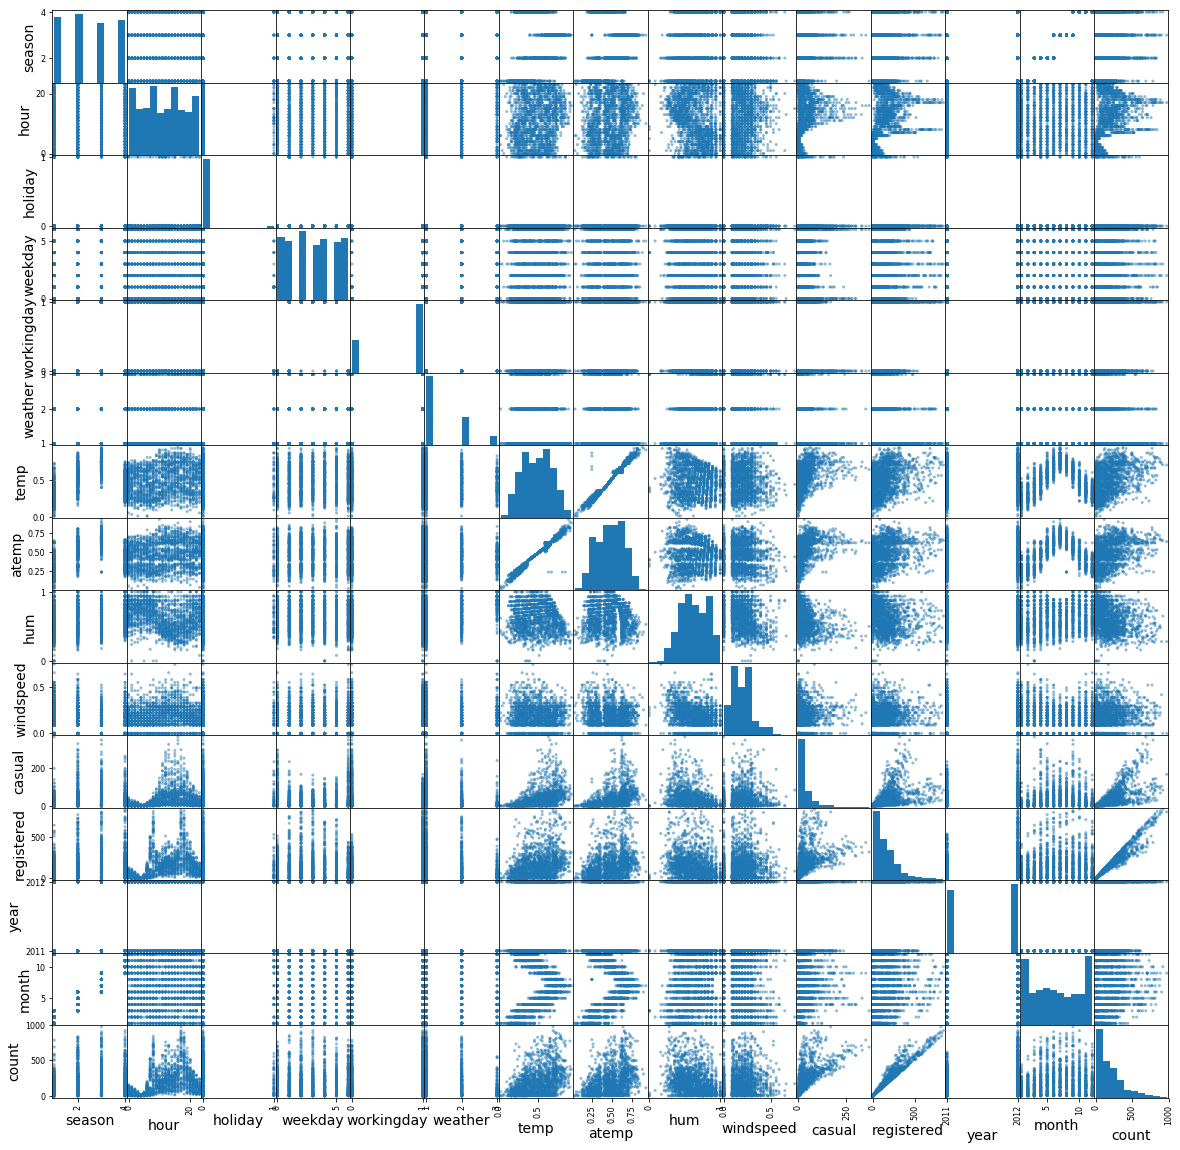

In [10]:
scatter_matrix(rand_sample, figsize=(20,20))
plt.show()

Positive correlations:

1. temp and atemp (these contain nearly the same information)
2. Casual/registered users and total count
3. Casual users and registered users
4. Temp/atemp and casual/registered/total counts

Negative correlations:

1. Humidity and casual/registered/total counts
2. Windspeed and casual/registered/total counts

Other relationships:

1. casual/registered/total counts vary by hour
2. temp/atemp/humidity vary by hour
3. temp/atemp vary by month

#### **2.2** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

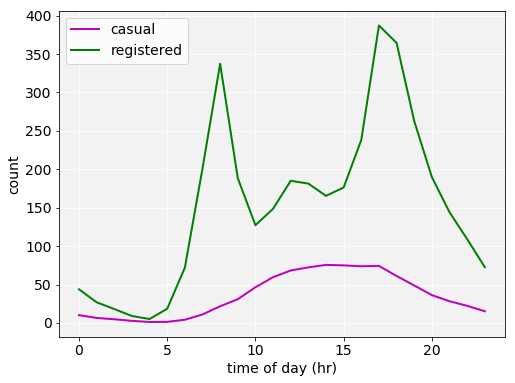

In [11]:
avg_by_hour = bikes_df.groupby('hour')['casual', 'registered'].mean()

plt.plot(np.arange(0,24,1), avg_by_hour['casual'], c='m', label='casual')
plt.plot(np.arange(0,24,1), avg_by_hour['registered'], c='g', label='registered')
plt.xlabel('time of day (hr)')
plt.ylabel('count')
plt.legend()
plt.grid(color='w')
plt.gca().set_facecolor([.95,.95,.95])

Registered users seem to peak in the morning and late afternoon, as is consistent with work commute. Casual users peak in the midday, suggesting that casual users likely use the bikes for joy rides.

#### **2.3** Use the variable `weather` to show how each weather category affects the relationships in question 2.2.  What do you observe?

In [12]:
def facet_stack(df, col, x=None, rows=None):

    if rows is None:
        rows = df.columns
    if x is None:
        x = df.columns
    
    axes_handles = np.empty((0,0))
    for i in x:
        for r in rows:
            g = sns.FacetGrid(df, col=col)
            g.map(plt.scatter, i, r, edgecolor='w')
            axes_handles = np.append(axes_handles, g.axes)
    
    return(axes_handles)

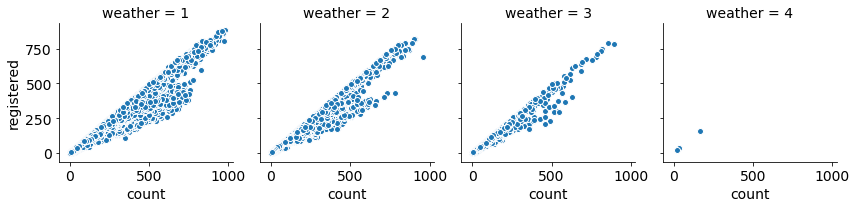

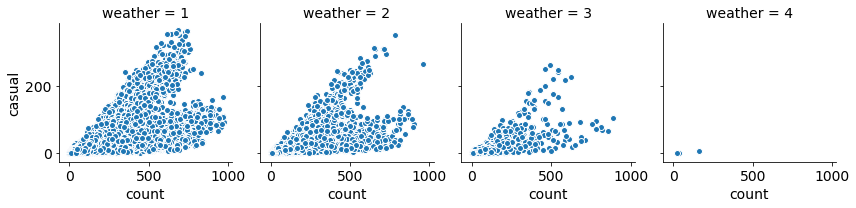

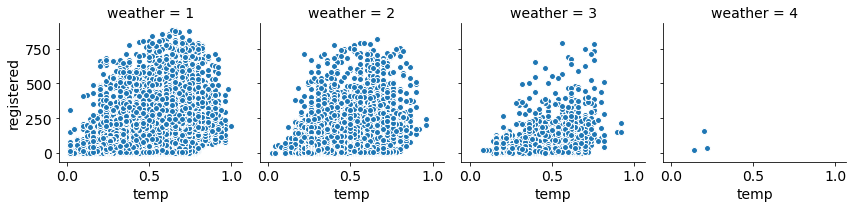

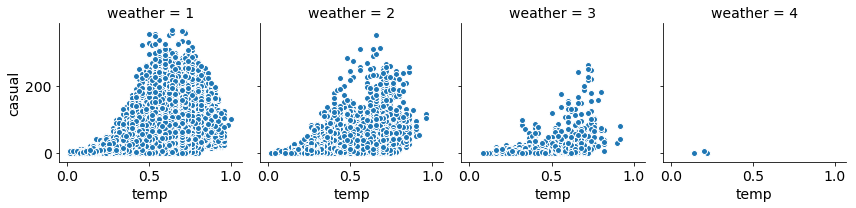

In [13]:
ah = facet_stack(bikes_df, 'weather', x=['count','temp'], rows=['registered','casual'])

The trends don't really seem to change qualitatively by weather category, but there is a clear reduction in all bike rides with increasingly inclimate weather.

#### **2.4** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature (normalized)
- `atemp`, the average atemp that day (normalized)
- `windspeed`, the average windspeed that day (normalized)
- `hum`, the average humidity that day (normalized)
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

#### Name this dataframe `bikes_by_day`.

#### Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

In [14]:
norm = preprocessing.MinMaxScaler()

# group the data by dteday to get unique dates
by_dteday = bikes_df.groupby("dteday")

# create dictionary with new measurements
by_day_dict = {
    "dteday": by_dteday.dteday.unique(),
    "weekday": by_dteday.weekday.mean(),
    "weather": by_dteday.weather.max(),
    "season": by_dteday.season.mean(),
    "temp": np.squeeze(norm.fit_transform(by_dteday.temp.mean().values.reshape(-1,1))),
    "atemp": np.squeeze(norm.fit_transform(by_dteday.atemp.mean().values.reshape(-1,1))),
    "windspeed": np.squeeze(norm.fit_transform(by_dteday.windspeed.mean().values.reshape(-1,1))),
    "hum": np.squeeze(norm.fit_transform(by_dteday.hum.mean().values.reshape(-1,1))),
    "casual": by_dteday.casual.sum(),
    "registered": by_dteday.registered.sum(),
    "counts": by_dteday["count"].sum(),

}

# intialize new data frame from dictionary
bikes_by_day = pd.DataFrame.from_dict(by_day_dict)


In [15]:
def hist_bygroup(df, grp_name: str, cols, figsize=None):

    # group data
    grp_df = df.groupby(grp_name)
    
    if type(cols) is not list:
        cols = list(cols)
    
    # get subplot dimensions
    ncol = len(grp_df.groups.keys())
    sp_cols = np.ceil(np.sqrt(ncol))
    sp_rows = np.ceil(ncol/sp_cols)
    
    if figsize is not None:
        plt.figure(figsize=figsize)
    
    i=1
    for key, grp in grp_df:
        plt.subplot(sp_rows,sp_cols,i)
        grp = grp_df.get_group(key)
        
        for col in cols:
            plt.hist(grp[col], label=col, alpha=0.5)
        
        plt.legend()
        plt.xlabel("fraction total")
        if key is not str:
            key = str(key)
        plt.title("%s = %s"% (grp_name,key))
        i+=1
        
    plt.subplots_adjust(hspace=0.5)

In [16]:
# create new temp df for visualization
counts = bikes_by_day[["casual","registered"]].values
weekday = bikes_by_day[["weekday","weekday"]].values.flatten(order="F").reshape(-1,1)
is_casual = np.concatenate((np.full((counts.shape[0],1),True),np.full((counts.shape[0],1),False)), axis=1).flatten(order="F")
counts = counts.flatten(order="F")
vis_df = pd.DataFrame(data = np.concatenate((counts.reshape(-1,1),is_casual.reshape(-1,1),weekday),axis=1),\
                     columns = ["counts","is_casual","weekday"])

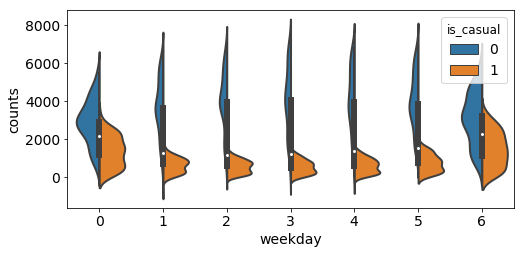

In [17]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
sns.violinplot(x='weekday', y="counts", hue="is_casual", split=True, data=vis_df)

#### **2.5** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

Text(0,0.5,'total rides per day')

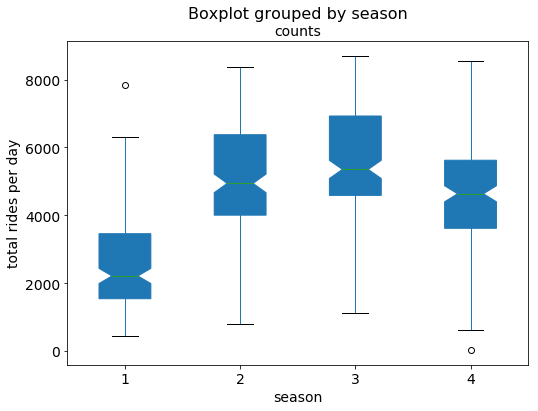

In [18]:
#g = sns.FacetGrid(bikes_by_day, col='season')
#g.map(plt.hist, "counts")
bp = bikes_by_day.boxplot(column='counts',by='season', notch=True, patch_artist=True, grid=False)
bp.set_xlabel("season")
bp.set_ylabel("total rides per day")

In [19]:
from scipy.stats import iqr
by_season = bikes_by_day.groupby("season")
season_count_iqrs = by_season['counts'].apply(iqr).values
season_count_percentiles = by_season['counts'].apply(lambda x: np.percentile(x,(25,75))).values

In [20]:
outlier_dates = []

i=0
for key, season in by_season:
    grp = by_season.get_group(key)
    lower_bound = season_count_percentiles[i][0] - season_count_iqrs[i]*1.5
    upper_bound = season_count_percentiles[i][1] + season_count_iqrs[i]*1.5
    is_outlier = np.array([[grp.counts.values < lower_bound],[grp.counts.values > upper_bound]]).reshape(-1,2).squeeze()
    is_outlier = is_outlier.any(axis=1)
    outlier_dates.append(grp.dteday[is_outlier])
    i+=1

In [21]:
for date in outlier_dates:
    if date.values.size > 0:
        print(date.values)

[array(['2012-12-24T00:00:00.000000000'], dtype='datetime64[ns]')]
[array(['2011-11-24T00:00:00.000000000'], dtype='datetime64[ns]')]


There are two outliers in the dataset:

1. Nov. 24, 2011 (Thanksgiving)
2. Dec. 24, 2012 (Christmas Eve)

Since these dates are holidays, these are most likely genuine outliers and not recording errors.

<div class='exercise'> <b> Question 3: Prepare the data for Regression </b> </div>

In order to build and evaluate our regression models, a little data cleaning is needed.  In this problem, we will explicitly create binary variables to represent the categorical predictors, set up the train-test split in a careful way, remove ancillary variables, and do a little data exploration that will be useful to consider in the regression models later.

**3.1** Using `bikes_df`, with hourly data about rentals, convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding**.

**3.2** Split the updated `bikes_df` dataset in a train and test part. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm. 

**3.3** Although we asked you to create your train and test set, but for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the he files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). Also, remove any predictors that would make predicting the `count` trivial. Note we gave more meaningful names to the one-hot encoded variables.



#### Answers

#### **3.1** Using `bikes_df`, with hourly data about rentals, convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding**.

In [22]:
bikes_df_recoded = pd.get_dummies(bikes_df, columns=['season', 'month', 'weekday', 'weather'], drop_first=True)

####  **3.2** Split the updated `bikes_df` dataset in a train and test part. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm.

In [23]:
train_df, test_df = train_test_split(bikes_df, test_size = 0.2, stratify=bikes_df['month'])

Using the `stratify` keyword-argument tells the train_test_split function to ensure that our categories of month are all equally represented in both the training and test data. This is particularly important if some of the categories are rare, meaning that its likely that a specific month(s) could be over or under-represented in the split data sets. This could bias our coefficient estimates our estimation of the goodness of fit.

#### **3.3** Although we asked you to create your train and test set, but for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the he files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). Also, remove any predictors that would make predicting the `count` trivial. Note we gave more meaningful names to the one-hot encoded variables.

In [24]:
def intialize_BSS_dfs():
    
    train_df = pd.read_csv("data/BSS_train.csv")
    test_df = pd.read_csv("data/BSS_test.csv")
    train_df = train_df.drop(columns=['Unnamed: 0', 'dteday', 'casual', 'registered'])
    test_df = test_df.drop(columns=['Unnamed: 0', 'dteday', 'casual', 'registered'])
    
    return(train_df, test_df)

In [25]:
train_df, test_df = intialize_BSS_dfs()
train_df.describe()

,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
count,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,...,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.000000,13903.00000,13903.000000
mean,11.529454,0.029274,0.504567,0.680644,0.496732,0.475426,0.629051,0.190025,187.885492,0.253183,...,0.085305,0.140977,0.141121,0.144861,0.140833,0.142128,0.145508,0.260375,0.08286,0.000144
std,6.917884,0.168580,0.499997,0.466244,0.192699,0.171951,0.193100,0.122009,180.113476,0.434850,...,0.279346,0.348010,0.348158,0.351973,0.347862,0.349194,0.352625,0.438855,0.27568,0.011993
min,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,6.000000,0.000000,0.000000,0.000000,0.340000,0.333300,0.480000,0.104500,39.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,11.000000,0.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,141.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,18.000000,0.000000,1.000000,1.000000,0.660000,0.621200,0.780000,0.253700,280.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000
max,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.850700,977.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


<div class='exercise'> <b> Question 4: Multiple Linear Regression </b> </div>

**4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.

**4.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). You should see some strange values, such as `July` producing 93 fewer rentals, all else equal, than January.

**4.3** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

**4.4** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from `X_train` with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

**4.5** The strange coefficients from 4.2 could also come from _multicolinearity_, where one or more predictors capture the same information as existing predictors. Why can multicolinearity lead to erroneous coefficient values? Create a temporary dataset `X_train_drop` that drops the following 'redundant' predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall`. Fit a multiple linear regression model to `X_train_drop`. Are the estimates more sensible in this model?


### Answers
#### **4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.

In [26]:
def train_test_score(train_df, test_df):
    
    train_mat = train_df.drop("counts", axis=1).values
    test_mat = test_df.drop("counts", axis=1).values

    X = sm.add_constant(train_mat)
    model = OLS(train_df.counts.values, X)
    model = model.fit()
    pred_counts = model.predict(sm.add_constant(test_mat))
    print('training data:\t r_squared = %.2f' % model.rsquared)
    print('test data:\t r_squared = %.2f' % r2_score(test_df.counts.values, pred_counts))
    
    return(model)

In [27]:
bike_ols = train_test_score(train_df, test_df)

training data:	 r_squared = 0.41
test data:	 r_squared = 0.41


#### **4.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). You should see some strange values, such as `July` producing 93 fewer rentals, all else equal, than January.

In [28]:
def coefficient_summary(df, model):
    p_vals = model.pvalues[1:]
    col_names = df.drop("counts", axis=1).columns
    coefs = model.params[1:]

    param_dicts = list([])
    for i in range(len(coefs)):
        new_param = {
            "name": col_names[i],
            "coefficient": coefs[i],
            "p_value": p_vals[i],
            "significant": p_vals[i] < 0.05,
        }
        param_dicts.append(new_param)

    param_df = pd.DataFrame.from_dict(param_dicts)
    return(param_df)

In [29]:
coef_df = coefficient_summary(train_df, bike_ols)
coef_df.head(len(coef_df))

,coefficient,name,p_value,significant
0,7.221382,hour,0.000000e+00,True
1,-18.095798,holiday,6.095043e-03,True
2,76.351903,year,6.205883e-218,True
3,11.317765,workingday,3.905740e-05,True
4,333.248241,temp,4.767468e-14,True
5,74.631221,atemp,1.062978e-01,False
6,-205.495864,hum,2.797780e-149,True
7,22.516841,windspeed,3.628163e-02,True
8,43.154064,spring,6.082058e-09,True
9,29.542551,summer,7.609902e-04,True


*your answer here*


#### **4.3** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

C:\Users\winsl0w\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'residual')

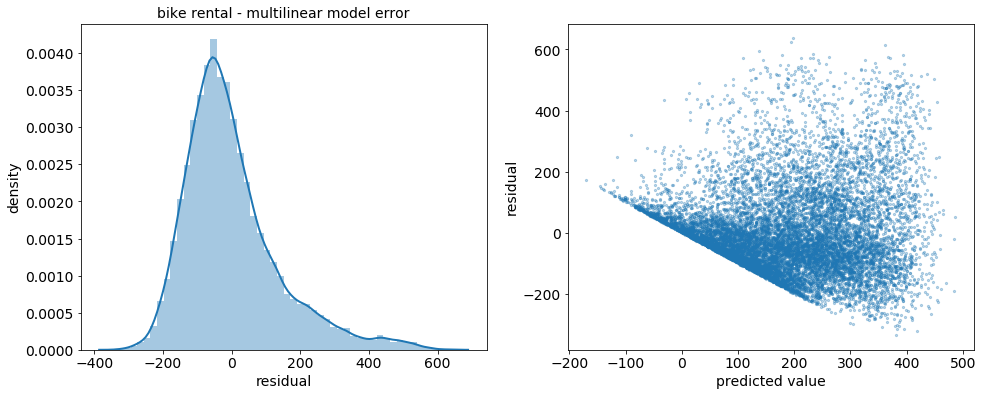

In [30]:
# create residual histogram plot
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.distplot(bike_ols.resid)
plt.xlabel("residual")
plt.ylabel("density")
plt.title("bike rental - multilinear model error")

# plot residual as a function of the predicted value
plt.subplot(1,2,2)
pred_counts = bike_ols.predict(sm.add_constant(train_df.drop("counts", axis=1).values))
plt.scatter(pred_counts, (train_df.counts.values - pred_counts), s=5, alpha=0.3)
plt.xlabel("predicted value")
plt.ylabel("residual")


*your answer here* 


#### **4.4** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from `X_train` with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

In [31]:
def add_poly_terms(df):
    # initialize new columns and add to train_df
    tmp_df = pd.DataFrame(data=df[["temp","hour","hum"]].values**2,\
                      columns=['temp_squared','hour_squared','hum_squared'],\
                      index=df.index)
    return(pd.concat([df, tmp_df], axis=1))

In [32]:
train_df, test_df = intialize_BSS_dfs()
train_df = add_poly_terms(train_df)
test_df = add_poly_terms(test_df)

In [33]:
X_train_poly = train_test_score(train_df, test_df)

training data:	 r_squared = 0.50
test data:	 r_squared = 0.50


In [34]:
coef_df = coefficient_summary(train_df, X_train_poly)
coef_df.head(len(coef_df))

,coefficient,name,p_value,significant
0,39.578636,hour,0.000000e+00,True
1,-13.006135,holiday,3.176951e-02,True
2,81.030524,year,9.565654e-284,True
3,13.289427,workingday,1.422985e-07,True
4,132.724741,temp,2.282248e-02,True
5,67.495690,atemp,1.210488e-01,False
6,11.863600,hum,7.425350e-01,False
7,-6.910041,windspeed,4.860598e-01,False
8,43.711567,spring,1.371673e-10,True
9,33.908698,summer,2.641910e-05,True


Ridership increases with temperature_squared and decreases with humidity_squared and hour_squared.

#### **4.5** The strange coefficients from 4.2 could also come from _multicolinearity_, where one or more predictors capture the same information as existing predictors. Why can multicolinearity lead to erroneous coefficient values? Create a temporary dataset `X_train_drop` that drops the following 'redundant' predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall`. Fit a multiple linear regression model to `X_train_drop`. Are the estimates more sensible in this model?

Multicolinearity occurs when two or more predictors are highly correlated. If they are strongly correlated enough, it means that the relationship between the correlated predictors and the response can largely be captured with a single coeficient. This can lead to erroneous coeficient values because it can lead to over or under stating the importance of correlated predictors.

In [35]:
# re-initialize dataframes
train_df, test_df = intialize_BSS_dfs()
train_df = add_poly_terms(train_df)
test_df = add_poly_terms(test_df)

In [36]:
# drop colinear predictors
train_df = train_df.drop(["workingday","atemp","spring","summer","fall"], axis=1)
test_df = test_df.drop(["workingday","atemp","spring","summer","fall"], axis=1)

In [37]:
X_train_drop = train_test_score(train_df, test_df)

training data:	 r_squared = 0.50
test data:	 r_squared = 0.49


In [38]:
# report parameter summary
coef_df = coefficient_summary(train_df, X_train_drop)
coef_df.head(len(coef_df))

,coefficient,name,p_value,significant
0,39.645146,hour,0.000000e+00,True
1,-32.600969,holiday,1.643900e-06,True
2,80.814108,year,4.298388e-280,True
3,231.986479,temp,2.436789e-10,True
4,8.502294,hum,8.116272e-01,False
5,-17.628074,windspeed,6.678293e-02,False
6,0.696760,Feb,9.003513e-01,False
7,22.626452,Mar,1.192497e-04,True
8,30.304500,Apr,2.016278e-06,True
9,36.752614,May,3.048655e-07,True


The parameter estimate for the months are much less negative than before. Most likely this is because the season parameters were capturing much of the effect of those parameters. The coefficient estimate for temp increased. This makes sense because the coefficients for temp and atemp before were both strongly positive and were highly correlated to each other. With atemp removed from the model, temp did not have to share the effect of temperature with another parameter. 

<div class='exercise'><b> Question 5: Subset Selection </b> </div>
Perhaps we can automate finding a good set of predictors. This question focuses on forward stepwise selection, where predictors are added to the model one by one.

**5.1** Implement forward step-wise selection to select a minimal subset of predictors that are related to the response variable. Run your code on the richest dataset, `X_train_poly`, and determine which predictors are selected.

We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the best subset size. 

<i>Note: Implementing from scratch means you are not allowed to use a solution provided by a Python library, such as sklearn or use a solution you found on the internet. You have to write all of the code on your own. However you MAY use the `model.bic` attribute implemented in statsmodels.</i>

**5.2** Does forward selection eliminate one or more of the colinear predictors we dropped in Question  4.5 (`workingday` `atemp` `spring` `summer` and `fall`)? If any of the five predictors are not dropped, explain why.

**5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the train and test $R^2$ scores for this fitted step-wise model compare with the train and test $R^2$ scores from the polynomial model fitted in Question 4.4?

### Answers

#### **5.1** Implement forward step-wise selection to select a minimal subset of predictors that are related to the response variable. Run your code on the richest dataset, `X_train_poly`, and determine which predictors are selected.

#### We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the best subset size. 

#### <i>Note: Implementing from scratch means you are not allowed to use a solution provided by a Python library, such as sklearn or use a solution you found on the internet. You have to write all of the code on your own. However you MAY use the `model.bic` attribute implemented in statsmodels.</i>

In [39]:
def get_model_BIC(x_data, y_data):
    
    model = OLS(y_data, sm.add_constant(x_data))
    model = model.fit()
    return(model.bic)

In [40]:
def best_kth_predictor(response, pred_confirmed, pred_candidates):
    
    pred_confirmed = pred_confirmed.values.reshape(pred_confirmed.shape[0],-1)
    BICs = np.empty(pred_candidates.shape[1])
    for i, col in enumerate(pred_candidates.columns):
        new_design_mat = np.concatenate((pred_confirmed,
                                        pred_candidates[col].values.reshape(-1,1)), axis=1)
        BICs[i] = get_model_BIC(new_design_mat,response)
        
    best_idx = np.argsort(BICs)
    return(pred_candidates.columns[best_idx[0]], BICs[best_idx[0]])
        


In [41]:
def forward_selection(response_data, pred_df):
    
    all_pred = pred_df.columns
    select_pred = []
    best_k_params_BIC = np.empty(len(all_pred))
    
    for k in range(len(all_pred)):
        curr_pred = list(set(select_pred) ^ set(all_pred))
        kth_pred, kth_BIC = best_kth_predictor(response_data,\
                                          pred_df[select_pred],\
                                          pred_df[curr_pred])
        best_k_params_BIC[k] = kth_BIC
        select_pred.append(kth_pred)
        
    return(select_pred, best_k_params_BIC)
        

In [42]:
train_df, test_df = intialize_BSS_dfs()
train_df = add_poly_terms(train_df)
test_df = add_poly_terms(test_df)

In [43]:
# do forward parameter selection
ordered_predictors, BICs = forward_selection(train_df.counts.values, train_df.drop("counts", axis=1))

In [44]:
# find model with minimum BIC
idx_sort = np.argsort(BICs)
best_predictors = ordered_predictors[:idx_sort[0]+1]
print("Best model has %i predictors (in order of importance): \n" % len(best_predictors))
print(*best_predictors, sep="\n")

Best model has 12 predictors (in order of importance): 

temp
hour
hour_squared
year
hum_squared
fall
Jul
Snow
spring
Sept
holiday
Cloudy


#### **5.2** Does forward selection eliminate one or more of the colinear predictors we dropped in Question  4.5 (`workingday` `atemp` `spring` `summer` and `fall`)? If any of the five predictors are not dropped, explain why.

Spring and Fall were not dropped from the model. One plausible reason why these twp predictors stayed in the model is because most of the spring and fall months (their colinear predictors), were removed from the model.

#### **5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the train and test $R^2$ scores for this fitted step-wise model compare with the train and test $R^2$ scores from the polynomial model fitted in Question 4.4?

In [45]:
# re-intialize dataframes
train_df, test_df = intialize_BSS_dfs()
train_df = add_poly_terms(train_df)
test_df = add_poly_terms(test_df)

In [46]:
# report polynomial model score
X_train_poly = train_test_score(train_df, test_df)

training data:	 r_squared = 0.50
test data:	 r_squared = 0.50


In [47]:
# restrict dataframes to best parameters
best_predictors.append("counts")
train_df = train_df[best_predictors]
test_df = test_df[best_predictors]

# report scores for best k parameters
best_k_model = train_test_score(train_df, test_df)

training data:	 r_squared = 0.50
test data:	 r_squared = 0.49


The $R^2$ values are essentially unchanged between the two models ($R^2\approx 0.5$)

#  Written Report to the Administrators [20 pts]
<br>

<div class='exercise'> <b> Question 6 </b> </div>

Write a short repost stating some of your findings on how the administrators can increase the bike share system's revenue. You might want to include suggestions such as what model to use to predict ridership, what additional services to provide, or when to give discounts, etc. 
Include your report as a pdf file in canvas. The report should not be longer than one page (300 words) and should include a maximum of 5 figures. 

#### Answers 6




*your answer here*


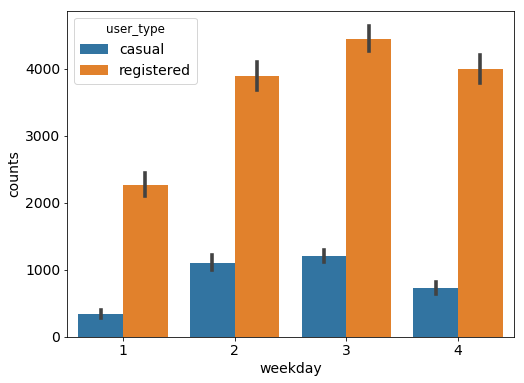

In [109]:
sns.barplot(x="weekday", y="counts", data=vis_df, hue="user_type")

In [82]:
# create new temp df for visualization
counts = bikes_by_day[["casual","registered"]].values
weekday = bikes_by_day[["weekday","weekday"]].values.flatten(order="F")
user = ["casual"] * counts.shape[0]
reg = ["registered"] * counts.shape[0]
user.extend(reg)
counts = counts.flatten(order="F")
data = {
    "counts": counts,
    "user_type": user,
    "weekday": weekday,
}
vis_df = pd.DataFrame.from_dict(data)

Text(0.5,1,'ride counts by day of the week')

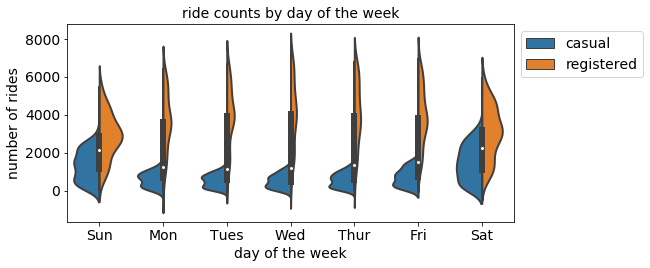

In [103]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
ax = sns.violinplot(x='weekday', y="counts", hue="user_type", split=True, data=vis_df)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xlabel("day of the week")
plt.ylabel("number of rides")
plt.xticks(np.arange(7),("Sun","Mon","Tues","Wed","Thur","Fri","Sat"))
plt.title("ride counts by day of the week")


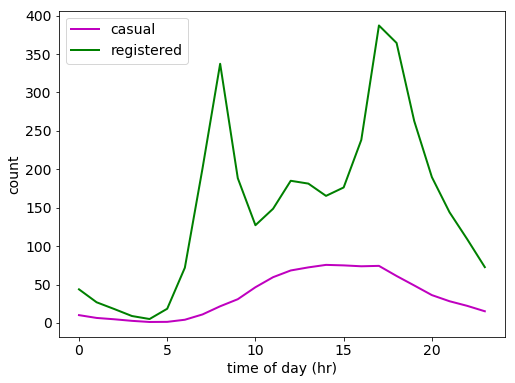

In [49]:
plt.plot(np.arange(0,24,1), avg_by_hour['casual'], c='m', label='casual')
plt.plot(np.arange(0,24,1), avg_by_hour['registered'], c='g', label='registered')
plt.xlabel('time of day (hr)')
plt.ylabel('count')
plt.legend()

In [105]:
# create new temp df for visualization
counts = bikes_by_day[["casual","registered"]].values
weekday = bikes_by_day[["season","season"]].values.flatten(order="F")
user = ["casual"] * counts.shape[0]
reg = ["registered"] * counts.shape[0]
user.extend(reg)
counts = counts.flatten(order="F")
data = {
    "counts": counts,
    "user_type": user,
    "weekday": weekday,
}
vis_df = pd.DataFrame.from_dict(data)

Text(0.5,1,'ride counts by season')

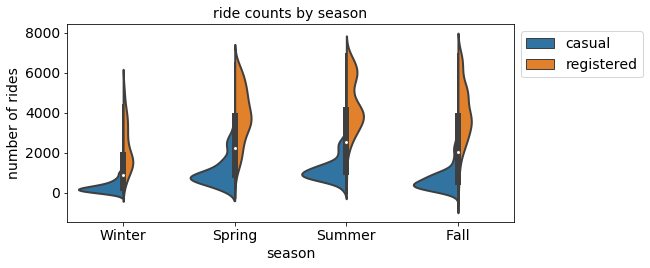

In [106]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
ax = sns.violinplot(x='weekday', y="counts", hue="user_type", split=True, data=vis_df)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xlabel("season")
plt.ylabel("number of rides")
plt.xticks(np.arange(4),("Winter","Spring","Summer","Fall"))
plt.title("ride counts by season")

*your answer here* 


*your answer here* 


In [ ]:
avg_counts